In [9]:
import pandas as pd
import numpy as np
from binance.client import Client
import time
from binance.client import Client
import pickle
from binance.enums import HistoricalKlinesType
import matplotlib.pyplot as plt
import warnings
import os
warnings.filterwarnings('ignore')
import json
import shutil  

Reading News File

In [10]:
df_news1 = pd.read_csv('news_20250225to20250510.csv')
df_news2 = pd.read_csv('news_20250510to20250526.csv')
df_news2 = df_news2[~df_news2['ID'].isin(df_news1['ID'])]
df_news = pd.concat([df_news1, df_news2])

df_news['count'] = 1
df_news['releasedAt'] = pd.to_datetime(df_news['releasedAt'])
df_news['releasedAt']

0       2025-02-25
1       2025-02-25
2       2025-02-25
3       2025-02-25
4       2025-02-25
           ...    
68217   2025-05-26
68218   2025-05-26
68219   2025-05-26
68220   2025-05-26
68221   2025-05-26
Name: releasedAt, Length: 309318, dtype: datetime64[ns]

Function to Fetch data from Binance

In [11]:
#Real account
api_key     = ""
api_secret  = ""
client_real = Client(api_key, api_secret)

# Binance API setup
API_KEY = ''  # Replace with your Binance API Key
API_SECRET = ''  # Replace with your Binance Secret Key
client = Client(API_KEY, API_SECRET)


def get_market_data(pair_name, time_frame, start_date, end_date, type_test='offline'):
    klines_hour = client_real.get_historical_klines(pair_name, time_frame, start_date, end_date ,klines_type=HistoricalKlinesType.SPOT)

    df_hour = pd.DataFrame(klines_hour, columns=['dateTime', 'open', 'high', 'low', 'close', 'volume', 'closeTime', 'quoteAssetVolume', 'numberOfTrades', 'takerBuyBaseVol', 'takerBuyQuoteVol', 'ignore'])
    df_hour.dateTime = pd.to_datetime(df_hour.dateTime, unit='ms')
    df_hour.closeTime = pd.to_datetime(df_hour.closeTime, unit='ms')
    # df_hour.set_index('dateTime', inplace=True)
    df_hour['close']  = df_hour['close'].apply(lambda x:float(x))
    df_hour['open']   = df_hour['open'].apply(lambda x:float(x))
    df_hour['high']   = df_hour['high'].apply(lambda x:float(x))
    df_hour['low']    = df_hour['low'].apply(lambda x:float(x))
    
    return df_hour

# data = get_market_data('BTCUSDT', '1m', '2025-05-10', '2025-05-27', type_test='offline')

In [12]:
data = get_market_data('BTCUSDT', '1m', '2025-02-25', '2025-05-27', type_test='offline')

In [13]:
data_btc = data.copy()

In [14]:
df_news_filtered = df_news[df_news['asset_symbols'].apply(lambda x: ('BTC' in str(x)) 
                                                          or ('ETH' in str(x)) or 
                                                          ('BNB' in str(x)) or 
                                                          ('SOL' in str(x)) or 
                                                          ('SHIB' in str(x)) or 
                                                          ('XRP' in str(x)) or 
                                                          ('BTC' in str(x)) or 
                                                          ('DAI' in str(x)))]
df_news_filtered.shape

(53810, 13)

In [15]:
df_news_filtered = df_news[df_news['asset_symbols'].apply(lambda x: ('BTC' in str(x))or ('ETH' in str(x)) or 
                                                          ('BNB' in str(x)))]
df_news_filtered.shape

(37675, 13)

In [16]:
df_news_minute = df_news_filtered[['releasedAt', 'count']].set_index('releasedAt').resample('1min').sum().reset_index()
df_news_minute

,releasedAt,count
0,2025-02-25 00:00:00,4
1,2025-02-25 00:01:00,1
2,2025-02-25 00:02:00,0
3,2025-02-25 00:03:00,0
4,2025-02-25 00:04:00,0
...,...,...
129596,2025-05-25 23:56:00,0
129597,2025-05-25 23:57:00,0
129598,2025-05-25 23:58:00,0
129599,2025-05-25 23:59:00,0


In [17]:
data_btc_merged = data_btc.merge(df_news_minute.rename(columns={'releasedAt': 'dateTime'}), on='dateTime', how='left')
data_btc_merged['count'] = data_btc_merged['count'].fillna(0)
data_btc_merged['rolling_count'] = data_btc_merged['count'].rolling(60*1).sum()
data_btc_merged = data_btc_merged.iloc[30200:]

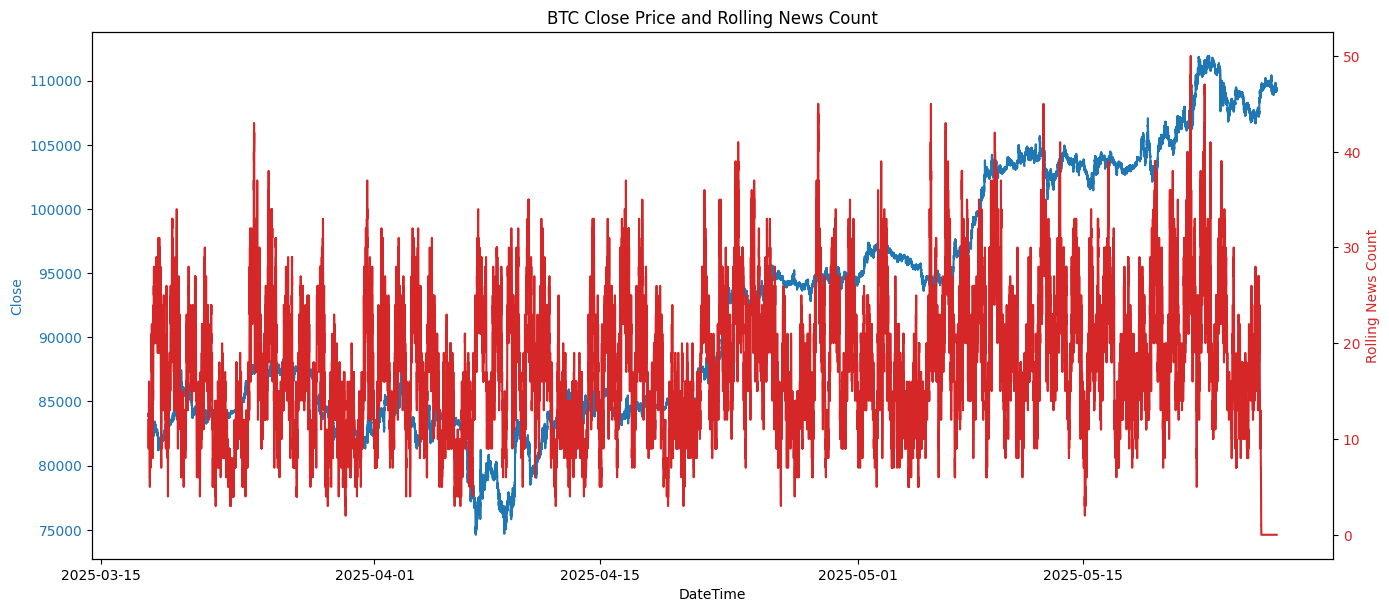

In [18]:
fig, ax1 = plt.subplots(figsize=(14, 6))

color = 'tab:blue'
ax1.set_xlabel('DateTime')
ax1.set_ylabel('Close', color=color)
ax1.plot(data_btc_merged['dateTime'], data_btc_merged['close'], color=color, label='Close')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Rolling News Count', color=color)
ax2.plot(data_btc_merged['dateTime'], data_btc_merged['rolling_count'], color=color, label='Rolling News Count')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('BTC Close Price and Rolling News Count')
plt.show()